# 1. Projected outcome profit per client

In [1]:
# import dependencies

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\denis\AppData\Local\Temp\ipykernel_22548\816365406.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Read in file
df = pd.read_csv('train_V2_cleaned.csv')

# Convert dummy features
df.iloc[:,25:58] = df.iloc[:,25:58].astype('category')

# Show conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   income_am              4947 non-null   float64 
 1   profit_last_am         4947 non-null   float64 
 2   profit_am              4947 non-null   float64 
 3   damage_am              4947 non-null   float64 
 4   damage_inc             4947 non-null   int64   
 5   crd_lim_rec            4947 non-null   float64 
 6   cab_requests           4947 non-null   int64   
 7   bar_no                 4947 non-null   int64   
 8   neighbor_income        4947 non-null   float64 
 9   age                    4947 non-null   int64   
 10  client_segment         4947 non-null   int64   
 11  sect_empl              4947 non-null   int64   
 12  fam_adult_size         4947 non-null   int64   
 13  children_no            4947 non-null   int64   
 14  tenure_mts             4947 non-null   i

In [3]:
# Dropping the features that need to be predicted EXCEPT the feature 'outcome_profit'.

drop_columns = ["outcome_damage_inc", "outcome_damage_amount"]

for col in drop_columns:
	if col in df.columns:
		df = df.drop(col, axis=1)

print("train", df.shape)

train (4947, 57)


## 1.1 Train/test-spit and standardisation

### 1.1.1 Shuffle data

In [4]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### 1.1.2 Train/test-split

In [5]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['outcome_profit'],1)
y = df_shuffle['outcome_profit']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=4321)

C:\Users\denis\AppData\Local\Temp\ipykernel_22548\2264054080.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_profit'],1)


### 1.1.3 Standardise

In [6]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

### 1.1.4 Polynomials - Penalisation

In [7]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.transform(X_val_stand)
X_train_poly.shape

(3165, 57)

The degree of the PolynomialFeatures is chosen to be 1. Choosing a degree higher than 1 will not only result in these values for the shape: (3165, 1770). But when executing the next cel, it would take more than 15 min to be finished. At the end these would be the values:

The optimal alpha is 1.0

The training score of the optimal alpha is (around 0.80)

The validation score of the optimal alpha is negative

In [8]:
# Using Cross validation to determine the best alpha for the Lasso regression

from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,0)
print(Alpha)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=3000)
    scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=3000)
train.fit(X_train_poly,y_train)

[0.001      0.0011514  0.00132571 0.00152642 0.00175751 0.00202359
 0.00232995 0.0026827  0.00308884 0.00355648 0.00409492 0.00471487
 0.00542868 0.00625055 0.00719686 0.00828643 0.00954095 0.01098541
 0.01264855 0.01456348 0.01676833 0.01930698 0.02222996 0.02559548
 0.02947052 0.03393222 0.0390694  0.04498433 0.05179475 0.05963623
 0.06866488 0.07906043 0.09102982 0.10481131 0.12067926 0.13894955
 0.15998587 0.184207   0.21209509 0.24420531 0.28117687 0.32374575
 0.37275937 0.42919343 0.49417134 0.5689866  0.65512856 0.75431201
 0.86851137 1.        ]


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+09, tolerance: 5.116e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+09, tolerance: 5.477e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Lasso(alpha=0.42919342601287785, max_iter=3000)

The optimal alpha is 0.42919342601287785
The training score of the optimal alpha is 0.3779936447012954
The validation score of the optimal alpha is 0.3164933293779317


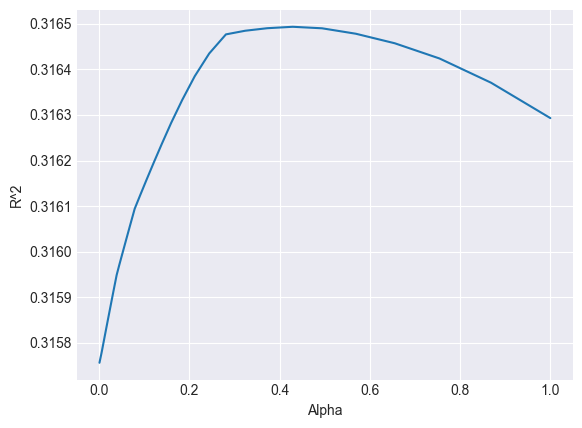

In [9]:
# plotting the best alpha

plt.plot(Alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

## 1.2 Polynomial regression

### 1.2.1 Cross-validation

In [10]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_poly, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.003842316952525504
Order 1: avg R^2 = 0.3152719900142802
Order 2: avg R^2 = -7.924404490897305e+24


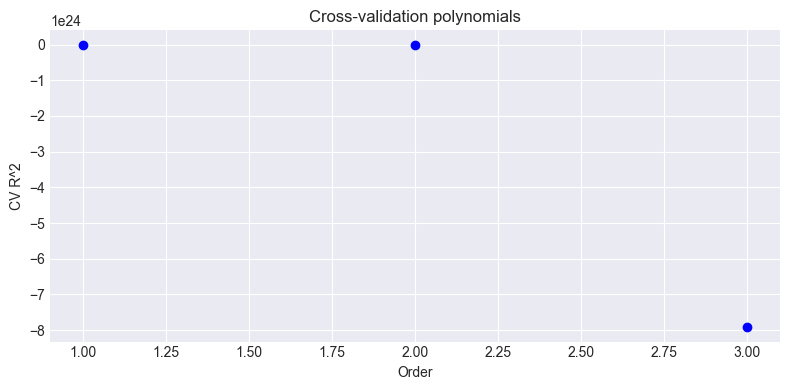

In [11]:
# Plotting the results

fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [12]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 1


In [13]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)
poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

print(str(poly_train_res) + "\n" + str(poly_val_res))

0.3776709188793932
0.49472008644597


# 1.3 K-nearest Neighbors

## 1.3.1 Cross-validation

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for k in K:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

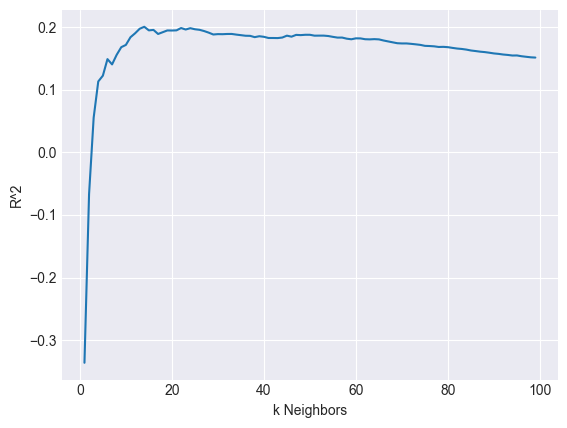

The best k is 14


In [15]:
# Plotting the results

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

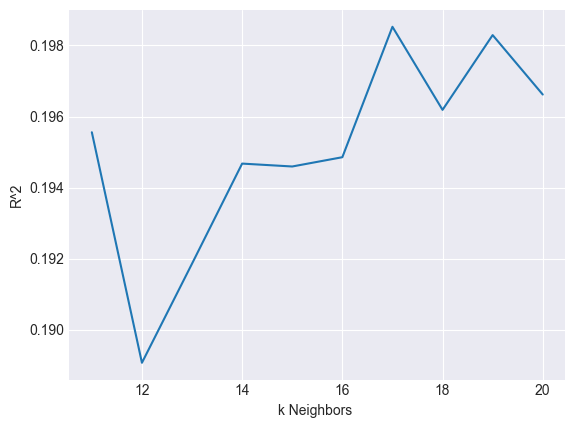

In [16]:
# let's zoom in to the nearest 15-25

plt.plot(K[10:20],cv_scores[15:25])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()

In [17]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)

knn_train_res = knn.score(X_train_stand, y_train)
knn_val_res = knn.score(X_val_stand, y_val)

print(str(knn_train_res) + "\n" + str(knn_val_res))

0.33385841955002327
0.3306063301723783


## 1.4 Radius Nearest Neighbors

### 1.4.1 Cross-validation

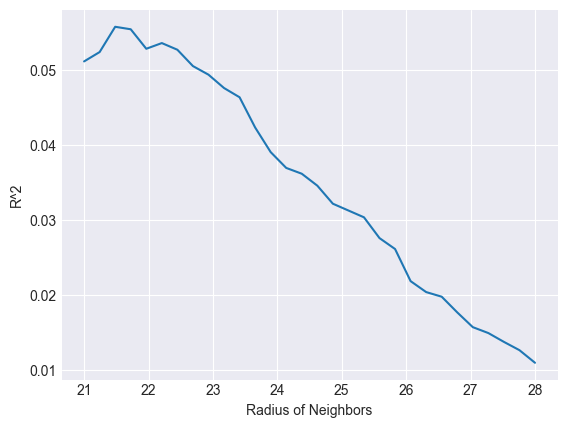

In [18]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(21,28,30)   
# This will give an array of numbers between 21 and 28 cross-validating using 30 values

cv_scores = []
sd_scores = []

# using a different radius each iteration. This will calculate and check which on in the best.

for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stand, y_train, cv=5)
    
    # store the average score
    cv_scores.append(scores.mean())
    
    # store the standard deviation of the score
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# plotting
plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors')
plt.ylabel('R^2')
plt.show()

In [19]:
# getting the best radius and validation score

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

print('The best radius is', Radius[max_index])

# retraining and testing

rnn_best = RadiusNeighborsRegressor(radius=Radius[max_index])
rnn_best.fit(X_train_stand, y_train)
print(rnn_best.score(X_train_stand, y_train))
print(max_value)

The best radius is 21.482758620689655
0.06772831980794669
0.055793610188460366


## 1.5 Decision trees

### 1.5.1 Cross-validation

In [20]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,50)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the  possible values for the radius (bandwidth)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

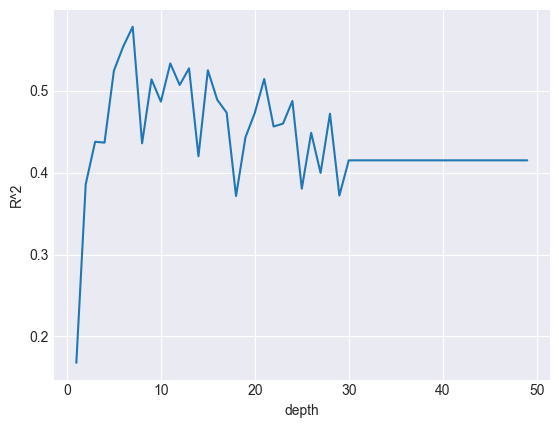

The best depth is 7
0.5779014982141613


In [21]:
# plotting the cross-validation

max_value_dt = max(cv_scores)
max_index_dt = cv_scores.index(max_value_dt)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index_dt])
print(max_value_dt)

In [22]:
# retraining and testing

dec_tree = DecisionTreeRegressor(random_state=0, max_depth=depth[max_index_dt])
dec_tree.fit(X_train_stand, y_train)

dt_train_res = dec_tree.score(X_train_stand, y_train)
dt_val_res = dec_tree.score(X_val_stand, y_val)

print(str(dt_train_res) + "\n" + str(dt_val_res))

0.8711727764018578
0.5760892914642732


## 1.6 Random Forest

### 1.6.1 Random search

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validation
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible

rf_random.fit(X_train_stand, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

In [24]:
# show the training and validated R^2 for the best model from the random search

best_rf_est = rf_random.best_estimator_

print(best_rf_est.score(X_train_stand, y_train))
print(best_rf_est.score(X_val_stand, y_val))

0.8169107464466562
0.7907003923905448


In [25]:
# retrieve the best parameters of the best model

rf_random.best_params_

{'n_estimators': 315,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 485,
 'max_features': 'auto',
 'max_depth': 6,
 'criterion': 'absolute_error'}

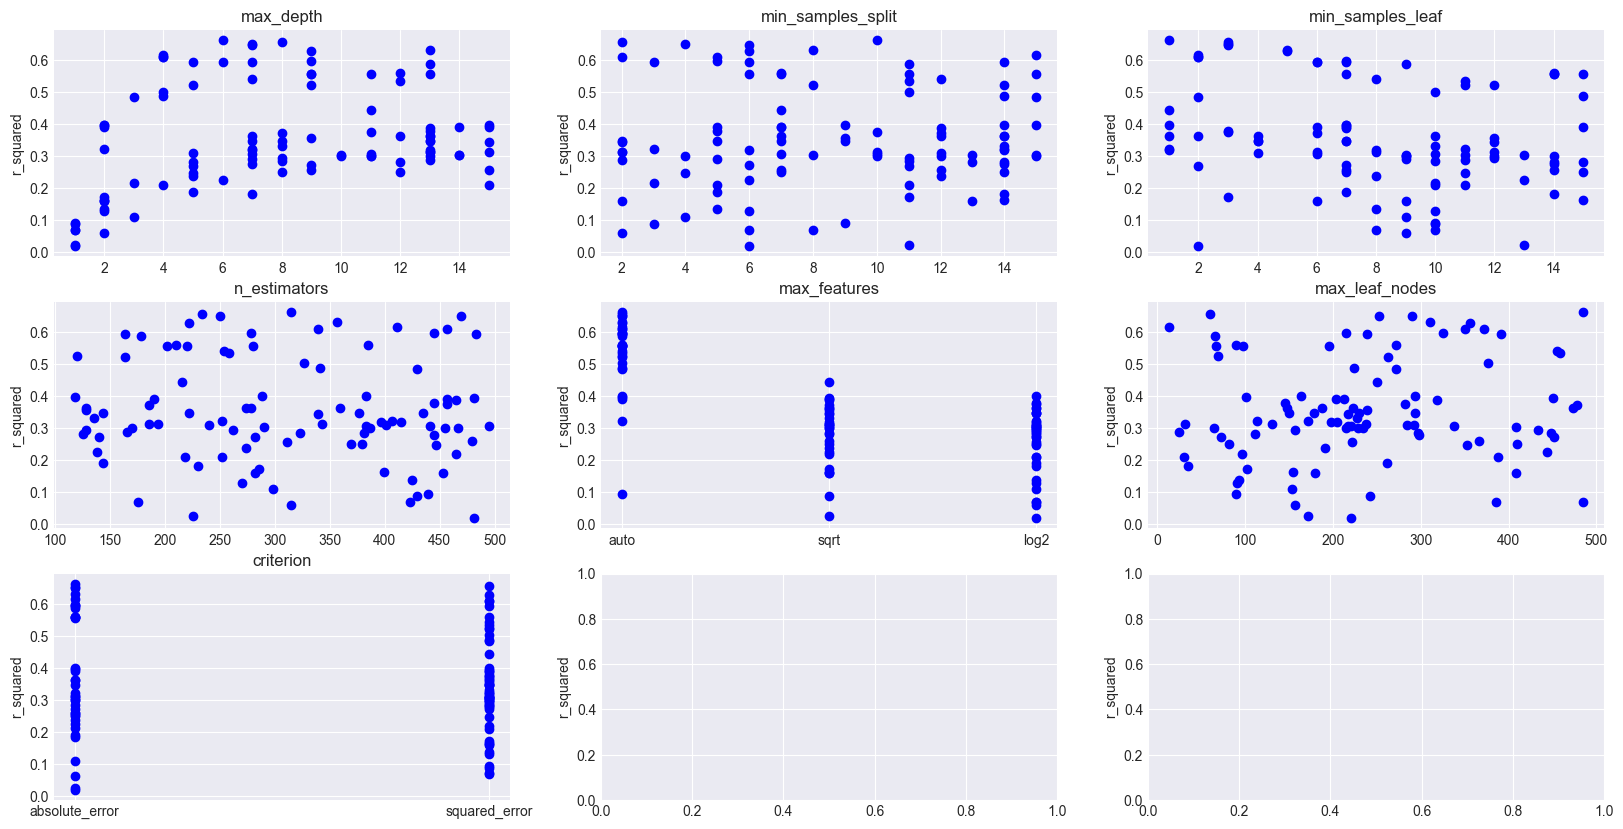

In [26]:
# plotting out the hyperparameters, so we can check which values to use for the grid search. 

out = pd.DataFrame(rf_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')


### 1.6.2 Grid search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315]
max_features = ['auto']
max_depth = [6,8]
min_samples_split = [2,10]
min_samples_leaf = [1,3]
max_leaf_nodes = [485]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 8],
                         'max_features': ['auto'], 'max_leaf_nodes': [485],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 10], 'n_estimators': [315]},
             verbose=2)

In [28]:
# show the training and validated R^2 for the best model from the random search

best_rf_grid_est = rf_grid.best_estimator_

rf_train_res = best_rf_grid_est.score(X_train_stand, y_train)
rf_val_res = best_rf_grid_est.score(X_val_stand, y_val)

print(str(rf_train_res) + "\n" + str(rf_val_res))

0.8487020204247501
0.7957016327160513


In [29]:
# retrieve the best parameters of the best model

rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 485,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 315}

## 1.7 Whitening the black box

### 1.7.1 Plotting the best params

In [30]:
# Get the best params

params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)

c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(criterion='absolute_error', max_depth=8,
                      max_features='auto', max_leaf_nodes=485,
                      min_samples_split=10, n_estimators=315)

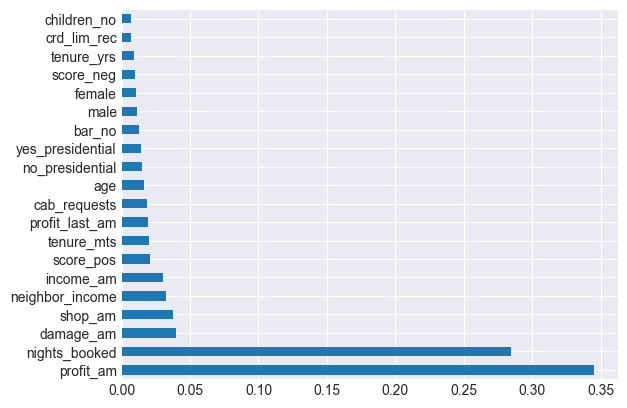

In [31]:
# Plot the 20 most important params

from matplotlib import pyplot as plt

plt.figure()

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### 1.7.2 Influence of a certain feature

In [32]:
# getting the prediction from the random forest

pred_train = rf_gridBest.predict(X_train_stand)

In [33]:
# Performing one univariate linear regression per feature on the predicted values.

from sklearn.linear_model import LinearRegression

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])
for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)
betas


,0,1
0,income_am,0.458035
0,profit_last_am,0.326769
0,profit_am,0.530826
0,damage_am,0.081130
0,damage_inc,0.041989
0,crd_lim_rec,-0.071504
0,cab_requests,0.008862
0,bar_no,0.029842
0,neighbor_income,0.103431
0,age,0.044549


it is not possible to install Lime using python 3.11.1, so we won't show the positives and negatives. You can vaguely grasp what is what using the chart above. 

## 1.8 Gradient boosting

### 1.8.1 Random search

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

gbm_random.fit(X_train_stand, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
237 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\base.py", line 581, in _validate_params
    val

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_node...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

In [35]:
# Show the validated R^2 for the best model from the random search
best_gbm_rand = gbm_random.best_estimator_

print(best_gbm_rand.score(X_train_stand, y_train)) # train
print(best_gbm_rand.score(X_val_stand, y_val)) # validation

0.8507120707783886
0.7396630695274137


In [36]:
# getting the best params for the best model form the random search 
gbm_random.best_params_

{'n_estimators': 189,
 'min_samples_split': 7,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 260,
 'max_features': 'auto',
 'max_depth': 7,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

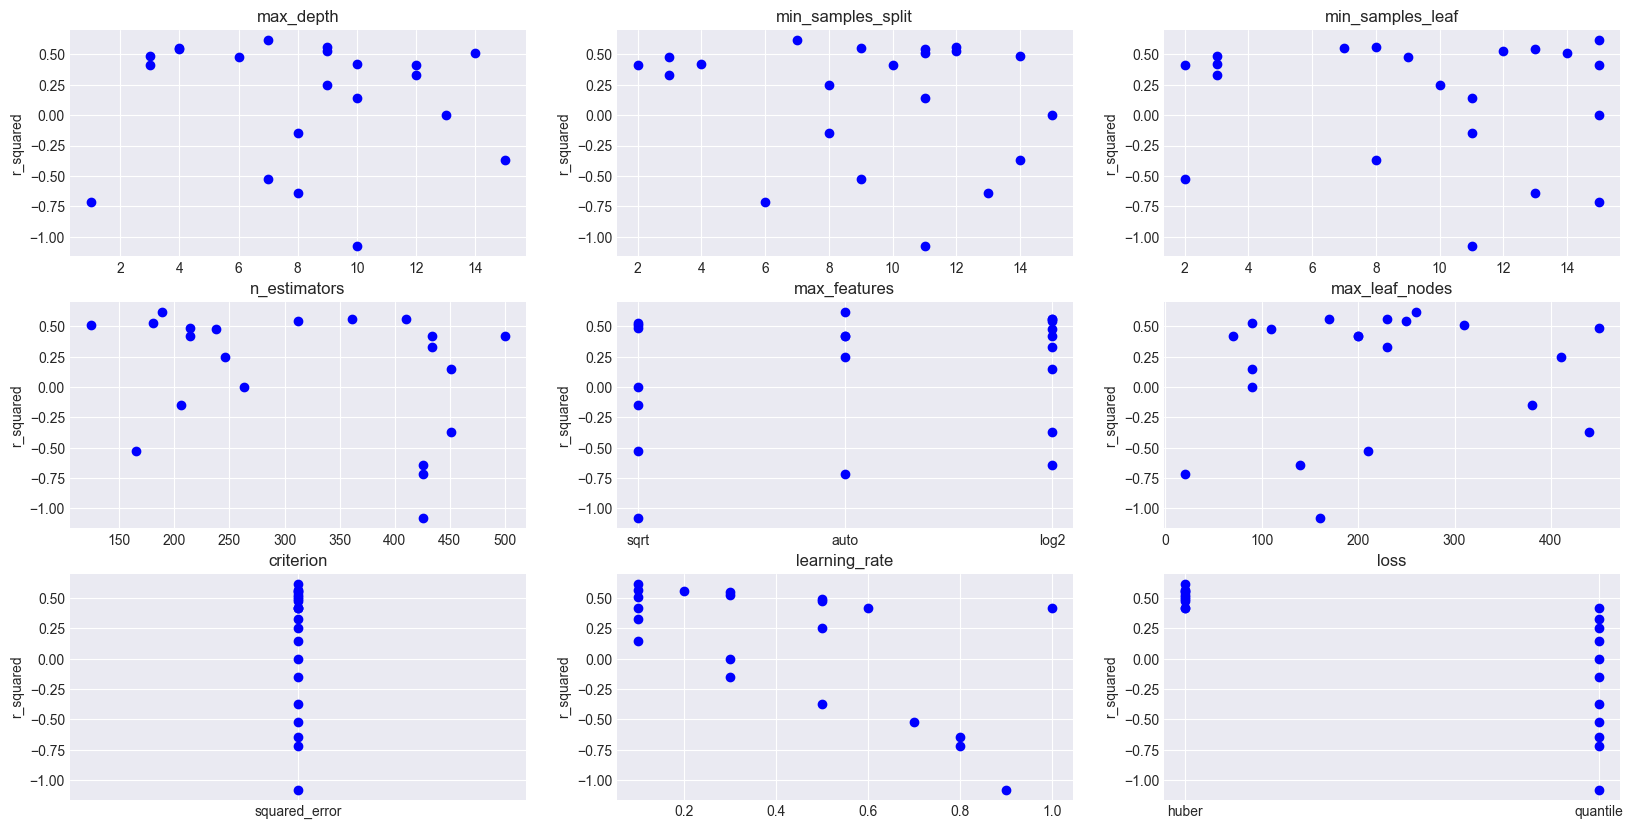

In [37]:
# plotting out the results of the hyperparameters

out = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

axs[2,1].scatter(out['param_learning_rate'], out['mean_test_score'], c='blue')
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out['param_loss'], out['mean_test_score'], c='blue')
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

### 1.8.2 Grid Search

In [38]:
from sklearn.model_selection import GridSearchCV

criterion =['squared_error']
n_estimators = [188,189]
max_features = ['auto']
max_depth = [7,9]
min_samples_split = [7,9]
min_samples_leaf = [8,15]
max_leaf_nodes = [260,245]
learning_rate = [0.1,0.2,0.25]
loss = ['squared_error']

# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid, cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
gbm_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past 

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.1, 0.2, 0.25],
                         'loss': ['squared_error'], 'max_depth': [7, 9],
                         'max_features': ['auto'], 'max_leaf_nodes': [260, 245],
                         'min_samples_leaf': [8, 15],
                         'min_samples_split': [7, 9],
                         'n_estimators': [188, 189]},
             verbose=2)

In [39]:
# show the training and validated R^2 for the best model
best_gbm = gbm_grid.best_estimator_

# calculate the training and validation scores of the best estimator

gb_train_res = best_gbm.score(X_train_stand, y_train)
gb_val_res = best_gbm.score(X_val_stand, y_val)

print(str(gb_train_res) + "\n" + str(gb_val_res))

0.958176641022288
0.7510484616792978


In [40]:
# retrieve the best parameters of the best model

gbm_grid.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 245,
 'min_samples_leaf': 8,
 'min_samples_split': 9,
 'n_estimators': 188}

# 1.9 Evaluation

In [41]:
# This code creates a table with the type of model and training and validation data. This is to ensure that each new change the evaluation is updated automatically.

from IPython.display import Markdown as md

table_template = "|Model|Train|Validation|\n| --- | --- | --- |\n|PolynomialRegressor|{poly_train:.1%}|{poly_val:.1%}|\n|KNearestNeighbor|{knn_train:.1%}|{knn_val:.1%}|\n|DecisionTree|{dt_train:.1%}|{dt_val:.1%}|\n|RandomForestRegressor|{rf_train:.1%}|{rf_val:.1%}|\n|GradientBoostingRegressor|{gb_train:.1%}|{gb_val:.1%}|"


md(table_template.format(poly_train=poly_train_res, poly_val=poly_val_res, knn_train=knn_train_res, knn_val=knn_val_res, dt_train=dt_train_res, dt_val=dt_val_res, rf_train=rf_train_res, rf_val=rf_val_res, gb_train=gb_train_res, gb_val=gb_val_res))

|Model|Train|Validation|
| --- | --- | --- |
|PolynomialRegressor|37.8%|49.5%|
|KNearestNeighbor|33.4%|33.1%|
|DecisionTree|87.1%|57.6%|
|RandomForestRegressor|84.9%|79.6%|
|GradientBoostingRegressor|95.8%|75.1%|

### 1.9.1 Fitting and predicting

In [42]:
# retraining (fitting) the best model on the unseen dataset

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315]
max_features = ['auto']
max_depth = [6,8]
min_samples_split = [2,10]
min_samples_leaf = [1,3]
max_leaf_nodes = [485]


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models parallel as possible

rf_grid.fit(X_val_stand, y_val)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\denis\.virtualenvs\project-KreOZjcw\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 8],
                         'max_features': ['auto'], 'max_leaf_nodes': [485],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 10], 'n_estimators': [315]},
             verbose=2)

In [62]:
# load dataset
score_cleaned = pd.read_csv('score_cleaned.csv')
current_predictions = pd.read_csv('current_predictions.csv')


# if the columns exists, remove it. This is to ensure when rerunning this cel, it doesn't break

if 'outcome_damage_amount' in score_cleaned.columns:
	score_cleaned.drop('outcome_damage_amount', axis=1, inplace=True)

if 'outcome_damage_inc' in score_cleaned.columns:
	score_cleaned.drop('outcome_damage_inc', axis=1, inplace=True)

if "outcome_profit" in score_cleaned.columns:
	score_cleaned.drop("outcome_profit", axis=1, inplace=True)

print(rf_grid.score(X_test_stand, y_test))

if "outcome_profit" not in score_cleaned.columns:
	# predict on the fitted model
	y_pred = rf_grid.predict(score_cleaned)

	score_cleaned["outcome_profit"] = [(round(n, 2)) for n in y_pred]
	current_predictions['outcome_profit'] = [(round(n, 2)) for n in y_pred]

	score_cleaned.to_csv('score_cleaned.csv', index=False)
	current_predictions.to_csv('current_predictions.csv', index=False)

0.6036967352829158
